In [1]:
%run resources.ipynb

dataset = 'GZ-Wikipedia-1M'
results_dir = 'Results/analysis/%s'%(dataset)
if not os.path.exists( results_dir ):
    os.makedirs( results_dir )
    
%run nns.ipynb

In [2]:
from xclib.utils.sparse import binarize
from xclib.utils.sparse import retain_topk
import random

In [3]:
RES_DIR = f'Results/{dataset}'
DATA_DIR = f'GZXML-Datasets/{dataset}'

In [4]:
plt.style.use('seaborn')

In [5]:
# import scipy.stats

# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return f'{"%.2f"%m} +- {"%.4f"%h}'

# def printacc(score_mat, K = 5, X_Y = None, num_splits=100, disp = False, inv_prop_ = -1):
#     if X_Y is None: X_Y = tst_X_Y
#     if inv_prop_ is -1 : inv_prop_ = inv_prop
#     rand_inds = np.random.permutation(score_mat.shape[0])
#     bsz = score_mat.shape[0]//num_splits
    
#     metrics = []
#     for ctr in range(0, score_mat.shape[0], bsz):
#         cur_rand_inds = rand_inds[ctr:ctr+bsz]
#         acc = xc_metrics.Metrics(X_Y[cur_rand_inds].tocsr().astype(np.bool), inv_prop_)
#         metrics.append(np.array(acc.eval(score_mat[cur_rand_inds], K))*100)
        
#     metrics = np.array(metrics)
#     result = np.empty_like(metrics[0], dtype=object)
    
#     for i in range(result.shape[0]):
#         for j in range(result.shape[1]):
#             result[i, j] = mean_confidence_interval(metrics[:, i, j])
#     df = pd.DataFrame(result)
    
#     if inv_prop_ is None : df.index = ['P', 'nDCG']
#     else : df.index = ['P', 'nDCG', 'PSP', 'PSnDCG']
        
#     df.columns = [str(i+1) for i in range(K)]
#     if disp: display(df)
#     return result

In [5]:
def restrict_mat(spmat, active_rows = None, active_cols = None, shrink=False):
    if active_cols is not None and active_rows is not None:
        temp = spmat[active_rows][:,active_cols]
    elif active_rows is not None: 
        temp = spmat[active_rows]
        if shrink: 
            active_cols = np.where(temp.getnnz(0)>0)[0]
            temp = temp[:, active_cols]
    elif active_cols is not None: 
        temp = spmat[:,active_cols]
        if shrink:
            active_rows = np.where(temp.getnnz(1)>0)[0]
            temp = temp[active_rows]
    else:
        if shrink:
            active_rows = np.where(spmat.getnnz(1)>0)[0]
            active_cols = np.where(spmat.getnnz(0)>0)[0]
            temp = spmat[active_rows][:,active_cols]
        else:
            return spmat, None, None
    
    return temp, active_rows, active_cols

def get_irm_metrics(score_mat, unseen = None, fewshot=None, X_Y=None):
    if X_Y is None : X_Y = tst_X_Y
    if unseen is None : unseen = unseen_labels
    if fewshot is None : fewshot = fewshot_labels
        
    mask = np.ones(tst_X_Y.shape[1], bool); mask[unseen] = False; seen = np.where(mask)[0]
    metrics = {'GZSL' : None, 'SZSL' : None, 'XC' : None}
    
    print(_c('GZSL metrics (shape=(%d, %d)): '%(X_Y.shape[0], X_Y.shape[1]), attr='bold'))
    metrics['GZSL'] = printacc(score_mat, X_Y=X_Y, K=5, inv_prop_=inv_prop)
    
    temp_X_Y, active_rows, _ = restrict_mat(X_Y, active_rows=None, active_cols=fewshot, shrink=True)
    temp_score_mat, _, _     = restrict_mat(score_mat, active_rows=active_rows, active_cols=fewshot, shrink=True)
    print(_c('FewShot metrics (shape=(%d, %d)): '%(temp_X_Y.shape[0], temp_X_Y.shape[1]), attr='bold'))
    metrics['FewShot'] = printacc(temp_score_mat, X_Y=temp_X_Y, K=5, inv_prop_=None)
    
    temp_X_Y, active_rows, _ = restrict_mat(X_Y, active_rows=None, active_cols=unseen, shrink=True)
    temp_score_mat, _, _     = restrict_mat(score_mat, active_rows=active_rows, active_cols=unseen, shrink=True)
    print(_c('SZSL metrics (shape=(%d, %d)): '%(temp_X_Y.shape[0], temp_X_Y.shape[1]), attr='bold'))
    metrics['SZSL'] = printacc(temp_score_mat, X_Y=temp_X_Y, K=5, inv_prop_=None)
    
    temp_X_Y, active_rows, _ = restrict_mat(X_Y, active_rows=None, active_cols=seen, shrink=True)
    temp_score_mat, _, _     = restrict_mat(score_mat, active_rows=active_rows, active_cols=seen, shrink=True)
    print(_c('XC metrics (shape=(%d, %d)): '%(temp_X_Y.shape[0], temp_X_Y.shape[1]), attr='bold'))
    metrics['XC'] = printacc(temp_score_mat, X_Y=temp_X_Y, K=5, inv_prop_=inv_prop[seen])
    
    del temp_score_mat, temp_X_Y, active_rows
    return metrics

In [6]:
def spmax(A, B):
    BisBigger = A-B
    BisBigger.data = np.where(BisBigger.data < 0, 1, 0)
    return A - A.multiply(BisBigger) + B.multiply(BisBigger)

## Binary Readers

In [7]:
size_dict = {bool : 1, np.int32 : 4, np.float32 : 4, np.int64 : 8}

def readbuf(buf, dtype, offset=0, count=1):
    val = np.frombuffer(buf, offset=offset, dtype=dtype, count=count)
    if count == 1: val = val[0]
    offset += size_dict[dtype]*count
    return val, offset

def read_buf_bin_vecif(buf, dtype, offset = 0, totlen = -1):
    if totlen < 0: totlen, offset = readbuf(buf, np.int64, offset, 1)
    totlen *= 2
    
    temp, _ = readbuf(buf, np.int32, offset, totlen)
    inds = temp.reshape(-1, 2)[:, 0];
    temp, offset = readbuf(buf, dtype, offset, totlen)
    data = temp.reshape(-1, 2)[:, 1];
    
    nr = 1
    if inds.shape[0] > 0: nr = inds.max()+1
    return csr_matrix((data, inds, [0, len(data)]), (1, nr)), offset

def read_buf_bin_vec(buf, dtype, offset = 0, totlen = -1):
    if totlen < 0: totlen, offset = readbuf(buf, np.int64, offset, 1)
    return readbuf(buf, dtype, offset, totlen)

def read_buf_bin_spmat(buf, dtype, offset = 0, old = False):
    (nr, nc), offset = readbuf(buf, np.int32, offset, 2)
    
    size = None
    if old: size, offset = read_buf_bin_vec(buf, np.int32, offset, nr)
    else: size, offset = read_buf_bin_vec(buf, np.int32, offset)

    data = []; inds = []; indptr = np.zeros(nr+1, int)
    indptr[1:] = size.cumsum()
    totlen = indptr[-1]
    temp, offset = read_buf_bin_vecif(buf, dtype, offset, totlen)

    return csr_matrix((temp.data, temp.indices, indptr), (nr, nc)), offset

def read_bin_spmat(fname, old = False):
    buf = open(fname, 'rb').read()
    print('loaded bin file in buffer')
    spmat, _ = read_buf_bin_spmat(buf, np.float32, 0, old)
    return spmat

In [8]:
class Node:
    is_leaf = None; is_end_leaf = None; is_early_leaf = None; X_routers = None; Y_routers = None;
    depth = None; children = None; Y = None; X = None; XY = None; parent = -1;
    
    def read(self, buf, offset, ind):
        self.id = ind
            
        [self.is_leaf, self.is_early_leaf, self.is_end_leaf], offset = readbuf(buf, bool, offset, 3)
        self.depth, offset = readbuf(buf, np.int32, offset, 1)
        self.children, offset = read_buf_bin_vec(buf, np.int32, offset)
        self.X, offset = read_buf_bin_vecif(buf, np.float32, offset)
        self.Y, offset = read_buf_bin_vecif(buf, np.float32, offset)
        self.xy_inds, offset = read_buf_bin_vec(buf, np.int32, offset)
                
        if self.id == 0:
            self.XY, offset = read_buf_bin_spmat(buf, np.int32, offset)
        
        if not self.is_leaf:
            self.X_routers, offset = read_buf_bin_spmat(buf, np.float32, offset)
            self.Y_routers, offset = read_buf_bin_spmat(buf, np.float32, offset)
            
        return offset
    
    def __str__(self):
        return  f'id : {self.id}\nparent : {self.parent}\nis_leaf : {self.is_leaf}\nis_early_leaf : {self.is_early_leaf}\
                \nis_end_leaf : {self.is_end_leaf}\nchildren : {self.children}\ndepth : {self.depth}\nnnz X : {self.X.nnz}\
                \nnnz Y : {self.Y.nnz}\nnnz XY : {self.xy_inds.shape[0]}\n'

    def __repr__(self):
        return  f'id : {self.id}\nparent : {self.parent}\nis_leaf : {self.is_leaf}\nis_early_leaf : {self.is_early_leaf}\
                \nis_end_leaf : {self.is_end_leaf}\nchildren : {self.children}\ndepth : {self.depth}\nnnz X : {self.X.nnz}\
                \nnnz Y : {self.Y.nnz}\nnnz XY : {self.xy_inds.shape[0]}\n'
    
class Tree:
    numxf = None; numyf = None; numx = None; numy = None; numxy = None; nodes = None; max_depth = None;
    shared_clf = None; ova_clf = None
    
    def read(self, filename, offset=0):
        buf = open(filename, 'rb').read()
        
        [self.numxf, self.numyf, self.numx, self.numy, self.numxy, numnode], offset = readbuf(buf, np.int32, offset, 6)
        self.nodes = np.empty(numnode, dtype=object)
        
        for i in tqdm(range(numnode)):
            nodeid, offset = readbuf(buf, np.int32, offset, 1)
            self.nodes[nodeid] = Node()
            offset = self.nodes[nodeid].read(buf, offset, nodeid)
        
        self.shared_clf, offset = read_buf_bin_vecif(buf, np.float32, offset)
        self.ova_clf, offset = read_buf_bin_spmat(buf, np.float32, offset)

In [9]:
from scipy.interpolate import make_interp_spline, BSpline

xnew = np.linspace(x.min(), x.max(), 300) 
spl = make_interp_spline(x, y, k=1)  # type: BSpline
smooth = spl(xnew)

# from scipy.ndimage.filters import gaussian_filter1d
# ysmoothed = gaussian_filter1d(y, sigma=10)

# plt.plot(x, ysmoothed)
plt.xlabel('number of training points', fontsize=18)
plt.ylabel('number of labels', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(xnew, smooth)
plt.yscale('log')
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)

plt.savefig('/mnt/c/Users/t-nilgup/Pictures/ads-label-frequency.png')
plt.savefig('/mnt/c/Users/t-nilgup/Pictures/ads-label-frequency.eps')

plt.show()

NameError: name 'x' is not defined

## Load Data

In [10]:
# val_X_Y = read_sparse_mat('%s/val_X_Y.txt'%DATA_DIR)
trn_X_Y = read_sparse_mat('%s/trn_X_Y.txt'%DATA_DIR)
tst_X_Y = read_sparse_mat('%s/tst_X_Y.txt'%DATA_DIR)
if os.path.exists('%s/pos_trn_tst.txt'%DATA_DIR): filter_mat = read_sparse_mat('%s/pos_trn_tst.txt'%DATA_DIR)
else : filter_mat = None
if os.path.exists('%s/pos_trn_val.txt'%DATA_DIR): val_filter_mat = read_sparse_mat('%s/pos_trn_val.txt'%DATA_DIR)
else : val_filter_mat = None

nnz = trn_X_Y.getnnz(0)
valid_labels = np.where(nnz > 0)[0]
unseen_labels = np.where(nnz == 0)[0]
fewshot_labels = np.where((nnz >= 0) & (nnz <= 5))[0]
inv_valid_labels = np.vectorize({v : i for i, v in enumerate(valid_labels)}.get)

if "Amazon" in dataset: A = 0.6; B = 2.6
elif "Wiki" in dataset: A = 0.5; B = 0.4
else : A = 0.55; B = 1.5
inv_prop = xc_metrics.compute_inv_propesity(trn_X_Y, A, B)

/home1/08343/nilesh/.local/lib/python3.7/site-packages/xclib-0.97-py3.7-linux-x86_64.egg/xclib/data/data_utils.py:263: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


In [12]:
with open(f'{DATA_DIR}/trn_X_Xf.txt') as f:
    nr, nc = map(int, f.readline().split(' '))
    data = []; indices = []; indptr = [0]
    cnt = 0
    for line in tqdm(f):
        if len(line) > 1:
            row = [x.split(':') for x in line.split()]
            tempindices, tempdata = list(zip(*row))
            indices.extend(list(map(int, tempindices)))
            data.extend(list(map(float, tempdata)))
            indptr.append(indptr[-1]+len(tempdata))
        else:
            indptr.append(indptr[-1])
        cnt += 1
        if cnt > 1000:
            break
    trn_X_Xf = csr_matrix((data, indices, indptr), (cnt, nc))
    del data, indices, indptr

1000it [00:00, 1262.65it/s]


In [13]:
trn_X_Xf

<1001x1000000 sparse matrix of type '<class 'numpy.float64'>'
	with 356919 stored elements in Compressed Sparse Row format>

In [11]:
trn_X_Xf = read_sparse_mat(f'{DATA_DIR}/trn_X_Xf.txt', use_xclib=False)

32007it [00:12, 2546.38it/s]


KeyboardInterrupt: 

In [16]:
xfs = [x.strip() for x in open(f'{DATA_DIR}/Xf.txt').readlines()]


In [14]:
trnX = []
for i, line in enumerate(open(f'{DATA_DIR}/raw/trn_X.txt')):
    if i > 1000:
        break
    trnX.append(line.strip())

In [19]:
trnX[1]

'Autism about the classic autistic disorder other conditions sometimes called quot autism quot Autism spectrum the journal Autism journal pp semi indef pp move indef short description Neurodevelopmental disorder involving social difficulties and repetitive behavior bots deny Monkbot lt keep Monkbot from visiting this page gt Use dmy dates date January 2020 Use American English date August 2016 Infobox medical condition new name Autism image Autism stacking cans 2nd edit jpg alt Boy stacking cans caption Repetitively stacking or lining up objects is commonly associated with autism field Psychiatry symptoms Trouble with Interpersonal relationship social interaction impaired communication restricted interests repetitive behavior lt ref name Land2008 gt complications Social isolation employment problems family stress bullying self harm lt ref gt cite web title Autism spectrum disorder Symptoms and causes url https www mayoclinic org diseases conditions autism spectrum disorder symptoms cau

In [18]:
print(get_text(1, xfs, trn_X_Xf))

x = 1 : 
autism(0.58, 72348) autism spectrum(0.24, 588279) spectrum disord(0.23, 926751) disord(0.22, 148726) journal(0.18, 240077) spectrum(0.17, 420421) vauthor(0.14, 468084) journal vauthor(0.12, 761116) ref name(0.11, 887545) pmid(0.11, 358055) doi(0.11, 150521) cite journal(0.10, 626419) volum(0.10, 474488) doi 10(0.09, 667969) titl autism(0.08, 952048) children autism(0.08, 624034) page(0.08, 342442) behavior(0.07, 82661) disord journal(0.07, 665195) dsm5 gt(0.07, 669943) name dsm5(0.07, 814754) pediatr(0.07, 348764) asd(0.07, 68510) dsm5(0.06, 154046) issu(0.06, 233135) gt cite(0.06, 721631) cite(0.06, 121136) 10(0.06, 3840) autist(0.06, 72351) news2007(0.05, 321461) gt lt(0.05, 724392) social(0.05, 416770) name nih2016(0.05, 816506) nih2016 gt(0.05, 826406) nih2016(0.05, 323500) quot(0.05, 371584) pediatr aappubl(0.05, 849430) symptom(0.05, 433835) diagnosi(0.05, 146010) aappubl org(0.05, 559443) aappubl(0.05, 46108) 120 5(0.05, 508218) repetit(0.05, 380081) 1542 ped(0.05, 5104

In [27]:
tst_X_Xf = read_sparse_mat(f'{DATA_DIR}/tst_X_Xf.txt')

In [29]:
rand_inds = np.random.choice(np.arange(tst_X_Y.shape[0]), size=100000, replace=False)

In [31]:
write_sparse_mat(filter_mat[rand_inds], f'{DATA_DIR}/rand100k_pos_trn_tst.txt')
write_sparse_mat(tst_X_Xf[rand_inds], f'{DATA_DIR}/rand100k_tst_X_Xf.txt')
write_sparse_mat(tst_X_Y[rand_inds], f'{DATA_DIR}/rand100k_tst_X_Y.txt')

In [12]:
sp_pattern_mat = read_bin_spmat(f'{RES_DIR}/model/sparsity_pattern.bin')
trn_X_Xf = read_sparse_mat(f'{DATA_DIR}/trn_X_Xf.txt')
tst_X_Xf = read_sparse_mat(f'{DATA_DIR}/tst_X_Xf.txt')
val_X_Xf = read_sparse_mat(f'{DATA_DIR}/val_X_Xf.txt')
Y_Yf = read_sparse_mat(f'{DATA_DIR}/Y_Yf.txt')

xfs = [x.strip() for x in open(f'{DATA_DIR}/Xf.txt').readlines()]
yfs = [x.strip() for x in open(f'{DATA_DIR}/Yf.txt').readlines()]
trn_X = [x.strip() for x in open(f'{DATA_DIR}/raw/trn_X.txt').readlines()]
Y = [x.split(';', 1)[0].strip() for x in open(f'{DATA_DIR}/raw/Y.txt').readlines()]
tst_X = [x.strip() for x in open(f'{DATA_DIR}/raw/tst_X.txt').readlines()]
val_X = [x.strip() for x in open(f'{DATA_DIR}/raw/val_X.txt').readlines()]

loaded bin file in buffer


In [16]:
xfs = [x.strip() for x in open(f'{DATA_DIR}/Xf.txt').readlines()]
yfs = [x.strip() for x in open(f'{DATA_DIR}/Yf.txt').readlines()]

In [19]:
yfs

['2020',
 '235',
 'aa',
 'aar',
 'aau',
 'abandon',
 'abat',
 'abattoir',
 'abb',
 'abil',
 'abolit',
 'abroad',
 'abrog',
 'abruzzi',
 'abstract',
 'abus',
 'acceler',
 'access',
 'accessori',
 'accid',
 'accommod',
 'accompani',
 'account',
 'accumul',
 'accus',
 'acer',
 'acet',
 'aceton',
 'acetylen',
 'achiev',
 'acid',
 'acidif',
 'acoust',
 'acp',
 'acqui',
 'acquir',
 'acquisit',
 'acreag',
 'acryl',
 'act',
 'actinium',
 'action',
 'activ',
 'actor',
 'actual',
 'acupunctur',
 'ad',
 'adapt',
 'addict',
 'addit',
 'address',
 'aden',
 'adhes',
 'adig',
 'adjust',
 'adjuv',
 'administr',
 'admiss',
 'adolesc',
 'adopt',
 'adr',
 'advanc',
 'advantag',
 'advertis',
 'advic',
 'advis',
 'advisori',
 'advoc',
 'aegean',
 'aerat',
 'aerodrom',
 'aerodyn',
 'aeronaut',
 'aeroplan',
 'aerosol',
 'aesthet',
 'aetr',
 'afar',
 'affair',
 'afforest',
 'afghanistan',
 'africa',
 'african',
 'afsj',
 'age',
 'agenc',
 'agenda',
 'agent',
 'aggreg',
 'aggress',
 'agrarian',
 'agreement',
 

In [34]:
k=100000

inds = np.random.choice(range(tst_X_Xf.shape[0]), size=k, replace=False)
np.save(f'{DATA_DIR}/random{k}_tst_inds.npy', inds)
write_sparse_mat(tst_X_Xf[inds], f'{DATA_DIR}/random{k}_tst_X_Xf.txt')
write_sparse_mat(tst_X_Y[inds], f'{DATA_DIR}/random{k}_tst_X_Y.txt')

# inds = np.random.choice(range(trn_X_Xf.shape[0]), size=k, replace=False)
# np.save(f'{DATA_DIR}/random{k}_trn_inds.npy', inds)
# write_sparse_mat(trn_X_Xf[inds], f'{DATA_DIR}/random{k}_trn_X_Xf.txt')
# write_sparse_mat(trn_X_Y[inds], f'{DATA_DIR}/random{k}_trn_X_Y.txt')

In [35]:
write_sparse_mat(filter_mat[inds], f'{DATA_DIR}/random{k}_pos_trn_tst.txt')

## Load tree

In [218]:
tree = Tree()
tree.read(f'{RES_DIR}/0.tree.bin')

early_leaf_nodes = [i for i in range(tree.nodes.shape[0]) if tree.nodes[i].is_early_leaf]
end_leaf_nodes = [i for i in range(tree.nodes.shape[0]) if tree.nodes[i].is_end_leaf]

for i, node in enumerate(tree.nodes):
    for child in node.children:
        tree.nodes[child].parent = i

data = []
inds = []
indptr = [0]
for node in tqdm(tree.nodes):
    data.append(node.Y.data)
    inds.append(node.Y.indices)
    indptr.append(indptr[-1]+node.Y.nnz)
node_to_label = csr_matrix((np.hstack(data), np.hstack(inds), indptr), (tree.nodes.shape[0], tree.numy))

100%|██████████| 2791/2791 [00:00<00:00, 531669.66it/s]


## Evaluate

In [136]:
parabel_score_mat = read_sparse_mat(f'/scratch/nilesh/programs/XReg/Source/Results/{dataset}/score_mat.txt', use_xclib=True)

In [16]:
all_metrics = {}

In [13]:
val_bilinear_score_mat = _filter(read_bin_spmat(f'{RES_DIR}/validation/bilinear_score_mat.bin').copy(), val_filter_mat)
val_knn_score_mat = _filter(read_bin_spmat(f'{RES_DIR}/validation/knn_score_mat.bin').copy(), val_filter_mat)

# # trn_xshortlist = read_bin_spmat(f'{RES_DIR}/trn_xshortlist.bin')
val_xshortlist = retain_topk(_filter(read_bin_spmat(f'{RES_DIR}/validation/shortlist.bin').copy(), val_filter_mat), k=100)

loaded bin file in buffer
loaded bin file in buffer
loaded bin file in buffer


In [32]:
score_mat = _filter(read_bin_spmat(f'{RES_DIR}/score_mat.bin').copy(), filter_mat[rand_inds])

loaded bin file in buffer


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [51]:
knn_score_mat = _filter(read_bin_spmat(f'{RES_DIR}/knn_score_mat.bin').copy(), filter_mat[rand_inds])
bilinear_score_mat = _filter(read_bin_spmat(f'{RES_DIR}/bilinear_score_mat.bin').copy(), filter_mat[rand_inds])

loaded bin file in buffer


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


loaded bin file in buffer


In [79]:
knn_score_mat = _filter(read_bin_spmat(f'{RES_DIR}/knn_score_mat.bin').copy(), filter_mat)
bilinear_score_mat = _filter(read_bin_spmat(f'{RES_DIR}/bilinear_score_mat.bin').copy(), filter_mat)

loaded bin file in buffer
loaded bin file in buffer


In [82]:
temp = 0.9*bilinear_score_mat + 0.1*knn_score_mat

In [83]:
printacc(temp, X_Y=tst_X_Y);

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,91.87,87.27,82.03,75.38,68.61
nDCG,91.87,88.55,85.75,83.52,82.10
PSP,49.18,55.80,60.37,63.33,65.27
PSnDCG,49.18,54.16,57.58,59.98,61.61


In [14]:
get_irm_metrics(score_mat, X_Y=tst_X_Y);

GZSL metrics (shape=(6000, 4271)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,91.87,87.27,82.03,75.38,68.61
nDCG,91.87,88.55,85.75,83.52,82.10
PSP,49.18,55.80,60.37,63.33,65.27
PSnDCG,49.18,54.16,57.58,59.98,61.61


FewShot metrics (shape=(524, 1930)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,38.93,26.34,20.42,16.70,13.89
nDCG,38.93,42.32,45.23,46.99,47.81


SZSL metrics (shape=(89, 163)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,29.21,18.54,14.61,10.96,8.76
nDCG,29.21,31.45,34.82,34.82,34.82


XC metrics (shape=(6000, 4108)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,91.87,87.27,82.06,75.42,68.65
nDCG,91.87,88.55,85.80,83.59,82.19
PSP,51.07,57.41,61.93,64.79,66.67
PSnDCG,51.07,55.84,59.22,61.56,63.13


In [16]:
# score_mat = 0.55*normalize(val_xshortlist, axis=1, norm='max') + 0.45*normalize(val_knn_score_mat, axis=1, norm='max')
# score_mat = 0.8*normalize(val_bilinear_score_mat, axis=1, norm='max') + 0.2*normalize(val_knn_score_mat, axis=1, norm='max')
# score_mat = 0.85*normalize(val_bilinear_score_mat, axis=1, norm='max') + 0.15*normalize(val_knn_score_mat, axis=1, norm='max') + 0.*normalize(val_xshortlist, axis=1, norm='max')
score_mat = 0.85*val_bilinear_score_mat + 0.15*val_knn_score_mat

In [17]:
metrics = get_irm_metrics(score_mat, X_Y=val_X_Y);

GZSL metrics (shape=(6000, 4271)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,91.07,87.06,81.67,75.15,68.53
nDCG,91.07,88.11,85.15,82.89,81.67
PSP,49.83,56.78,60.91,63.89,66.06
PSnDCG,49.83,55.03,58.21,60.58,62.31


FewShot metrics (shape=(510, 1930)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,42.75,27.06,20.00,15.78,13.25
nDCG,42.75,44.95,46.47,47.32,48.37


SZSL metrics (shape=(87, 163)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,34.48,21.26,14.56,11.49,9.20
nDCG,34.48,36.49,37.07,37.87,37.87


XC metrics (shape=(6000, 4108)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,91.08,87.13,81.74,75.25,68.62
nDCG,91.08,88.17,85.23,83.00,81.81
PSP,51.75,58.54,62.53,65.42,67.57
PSnDCG,51.75,56.84,59.91,62.23,63.93


In [7]:
rand_inds = np.load(f'{DATA_DIR}/random100000_tst_inds.npy')

In [21]:
# tst_clf_score_mat = retain_topk(_filter(read_bin_spmat(f'{RES_DIR}/clf_score_mat.bin').copy(), filter_mat), k=100)
tst_bilinear_score_mat = retain_topk(_filter(read_bin_spmat(f'{RES_DIR}/bilinear_score_mat.bin').copy(), filter_mat), k=100)
tst_knn_score_mat = retain_topk(_filter(read_bin_spmat(f'{RES_DIR}/knn_score_mat.bin').copy(), filter_mat), k=100)

# # trn_xshortlist = read_bin_spmat(f'{RES_DIR}/trn_xshortlist.bin')
tst_xshortlist = retain_topk(_filter(read_bin_spmat(f'{RES_DIR}/shortlist.bin').copy(), filter_mat), k=100)

loaded bin file in buffer
loaded bin file in buffer
loaded bin file in buffer


In [31]:
score_mat = 0.9*tst_bilinear_score_mat + 0.1*tst_knn_score_mat
# score_mat = 0.4*tst_knn_score_mat + 0.6*tst_xshortlist
# score_mat = 0.25*tst_knn_score_mat + 0.65*tst_clf_score_mat + 0.1*tst_xshortlist

In [32]:
metrics = get_irm_metrics(tst_bilinear_score_mat, X_Y=tst_X_Y);
# myprint(*metrics['GZSL'][0, [0, 2, 4]], *metrics['FewShot'][0, [0, 2, 4]], *metrics['SZSL'][0, [0, 2, 4]], *metrics['GZSL'][2, [0, 2, 4]], sep=';')

GZSL metrics (shape=(6000, 4271)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,91.72,87.28,81.98,75.42,68.60
nDCG,91.72,88.52,85.70,83.51,82.08
PSP,48.60,55.56,60.16,63.20,64.98
PSnDCG,48.60,53.83,57.29,59.73,61.29


FewShot metrics (shape=(524, 1930)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,38.17,25.29,19.72,15.74,13.09
nDCG,38.17,41.34,44.30,45.31,45.98


SZSL metrics (shape=(89, 163)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,21.35,15.73,11.99,9.55,7.87
nDCG,21.35,25.28,27.31,28.28,28.71


XC metrics (shape=(6000, 4108)): 


/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,1,2,3,4,5
P,91.73,87.28,82.01,75.47,68.64
nDCG,91.73,88.53,85.74,83.60,82.18
PSP,50.53,57.20,61.75,64.71,66.45
PSnDCG,50.53,55.55,58.96,61.36,62.86


In [19]:
metrics = get_irm_metrics(tst_knn_score_mat, X_Y=tst_X_Y);
myprint(*metrics['GZSL'][0, [0, 2, 4]], *metrics['FewShot'][0, [0, 2, 4]], *metrics['SZSL'][0, [0, 2, 4]], *metrics['GZSL'][2, [0, 2, 4]], sep=';')

GZSL metrics (shape=(2705425, 1285321)): 
FewShot metrics (shape=(2294572, 986826)): 
SZSL metrics (shape=(2202574, 790214)): 
XC metrics (shape=(1787090, 495107)): 
18.68 +- 0.0744;11.56 +- 0.0991;8.61 +- 0.0924;18.95 +- 0.0634;11.09 +- 0.0297;8.04 +- 0.0153;19.12 +- 0.0639;11.11 +- 0.0246;8.01 +- 0.0178;17.55 +- 0.0729;15.60 +- 0.1408;16.03 +- 0.1713


In [12]:
myprint(*metrics['GZSL'][0, [0, 2, 4]], *metrics['FewShot'][0, [0, 2, 4]], *metrics['SZSL'][0, [0, 2, 4]], *metrics['GZSL'][2, [0, 2, 4]])

30.070 22.469 17.747 21.081 12.696 9.314 21.222 12.597 9.204 7.854 11.788 14.554


In [16]:
sp.save_npz(f'{RES_DIR}/final_score_mat.npz', score_mat)

In [75]:
tst_xshortlist = read_bin_spmat(f'{RES_DIR}/shortlist.bin').copy()

loaded bin file in buffer


In [94]:
parabel_score_mat = sp.load_npz(f'/mnt/c/nilesh/score_mat.npz')

In [13]:
tfidf_xshortlist = read_bin_spmat(f'/mnt/c/nilesh/wiki_tfidf_score_mat.bin').copy()

loaded bin file in buffer


In [79]:
def recall(spmat, X_Y = None, K = [1, 10, 50, 100]):
    if X_Y is None : X_Y = tst_X_Y.copy()
    X_Y.data[:] = 1
    ans = {}
    rank_mat = xclib.utils.sparse.rank(spmat)
    
    for k in K:
        temp = rank_mat.copy()
        temp.data[temp.data > k] = 0.0
        temp.eliminate_zeros()
        temp.data[:] = 1.0
        intrsxn = temp.multiply(X_Y)

        recall = (intrsxn.nnz/X_Y.nnz)
        ans['R@%d'%k] = recall*100
    
    return ans

In [151]:
recall(parabel_score_mat, X_Y=tst_X_Y[rand_inds], K=[50, 100, 500, 1000])

{'R@50': 30.001787499087367,
 'R@100': 32.193865605244675,
 'R@500': 32.193865605244675,
 'R@1000': 32.193865605244675}

In [14]:
nnz = trn_X_Y.getnnz(0)
lbl_freq = np.array(list(zip(np.arange(trn_X_Y.shape[1]), nnz, np.zeros(trn_X_Y.shape[1]))), dtype=object)
lbl_freq = lbl_freq[np.argsort(lbl_freq[:, 1])]
lbl_freq[:, 2] = np.cumsum(lbl_freq[:, 1])

In [15]:
totsum = lbl_freq[-1, 2]
deciles = np.array([lbl_freq[(lbl_freq[:, 2] > i*totsum/100) & (lbl_freq[:, 2] <= (i+10)*totsum/100)] for i in range(-10, 100, 10)])

/home/nilesh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [16]:
decile_mask = np.zeros((deciles.shape[0], trn_X_Y.shape[1]), bool)
for i, decile in enumerate(deciles):
    decile_mask[i, decile[:, 0].astype(int)] = True

In [17]:
axml_score_mat = retain_topk(sp.load_npz('/mnt/c/nilesh/wiki_mats/axml_score_mat.npz')[rand_inds], k=100)

In [18]:
parabel_score_mat = retain_topk(sp.load_npz('/mnt/c/nilesh/wiki_mats/parabel_score_mat.npz')[rand_inds], k=100)

In [19]:
dismec_score_mat = retain_topk(sp.load_npz('/mnt/c/nilesh/wiki_mats/dismec_score_mat.npz')[rand_inds], k=100)

In [ ]:
all_score_mats = 

In [20]:

all_score_mats = [('ZestXML', retain_topk(score_mat, k=100, copy=False)),
                 ('Tf-Idf', retain_topk(tfidf_xshortlist, k=100, copy=False)),
                 ('AttentionXML', axml_score_mat),
                 ('Parabel', parabel_score_mat),
                 ('DiSMEC', dismec_score_mat)]

In [35]:
tst_xshortlist.nnz / tst_xshortlist.shape[0]

100.0

In [43]:
points = {}

In [44]:
X_Y = tst_X_Y[rand_inds]
for method, _score_mat in all_score_mats:
    metrics = {}
    print('Method :', method)
#     for i, decile in enumerate(decile_mask):
    for i in range(6):
        best_score_mat = score_mat
        best_p5 = 0
        active_labels = np.where(nnz == i)[0]
        temp_X_Y, active_rows, _ = restrict_mat(X_Y, active_rows=None, active_cols=active_labels, shrink=True)
        
        if method == 'ZestXML':
            for alpha in tqdm(drange(0, 1, 0.1)):
                for beta in drange(0, alpha, 0.1):
                    gamma = 1-alpha-beta
                    combined = retain_topk(alpha*tst_clf_score_mat + beta*tst_bilinear_score_mat + gamma*tst_knn_score_mat, k=100, copy=False)
                    temp_score_mat, _, _ = restrict_mat(combined, active_rows=active_rows, active_cols=active_labels, shrink=True)
                    temp_metrics = printacc(temp_score_mat, X_Y=temp_X_Y, K=5, inv_prop_=None, disp=False)
                    if temp_metrics[0, 4] > best_p5:
                        best_p5 = temp_metrics[0, 4]
                        best_score_mat = combined
            _score_mat = best_score_mat
        
        temp_score_mat, _, _     = restrict_mat(_score_mat, active_rows=active_rows, active_cols=active_labels, shrink=True)
        print(_c('decile %d (shape=(%d, %d)): '%(i, temp_X_Y.shape[0], temp_X_Y.shape[1]), attr='bold'))
        metrics[i] = printacc(temp_score_mat, X_Y=temp_X_Y, K=5, inv_prop_=None)
        if method in points: points[method].append(metrics[i][0, 4])
        else: points[method] = [metrics[i][0, 4]]

0it [00:00, ?it/s]

Method : ZestXML


10it [03:15, 19.54s/it]


decile 0 (shape=(81546, 790214)): 


,1,2,3,4,5
P,21.24,15.79,12.60,10.62,9.20
nDCG,21.24,20.49,20.83,21.44,21.96


10it [02:14, 13.49s/it]

decile 1 (shape=(1361, 13536)): 


,1,2,3,4,5
P,37.55,24.69,17.93,14.03,11.43
nDCG,37.55,43.34,45.30,46.19,46.56


10it [02:20, 14.00s/it]

decile 2 (shape=(3358, 51177)): 


,1,2,3,4,5
P,30.52,19.40,14.49,11.52,9.57
nDCG,30.52,34.79,36.98,38.05,38.71


10it [02:25, 14.56s/it]

decile 3 (shape=(3931, 50942)): 


,1,2,3,4,5
P,33.73,21.44,15.76,12.64,10.54
nDCG,33.73,38.40,40.45,41.76,42.57


10it [02:25, 14.57s/it]

decile 4 (shape=(4122, 44045)): 


,1,2,3,4,5
P,37.48,23.16,16.98,13.40,11.11
nDCG,37.48,41.87,44.05,45.13,45.85


10it [02:25, 14.59s/it]

decile 5 (shape=(4211, 36912)): 


,1,2,3,4,5
P,38.16,24.20,17.76,13.97,11.49
nDCG,38.16,43.25,45.49,46.56,47.15


Method : Tf-Idf
decile 0 (shape=(81546, 790214)): 


,1,2,3,4,5
P,19.03,14.02,11.14,9.31,8.04
nDCG,19.03,18.29,18.61,19.09,19.55


decile 1 (shape=(1361, 13536)): 


,1,2,3,4,5
P,37.91,21.68,14.89,11.26,9.05
nDCG,37.91,39.65,40.12,40.21,40.26


decile 2 (shape=(3358, 51177)): 


,1,2,3,4,5
P,24.99,15.02,10.59,8.11,6.56
nDCG,24.99,27.52,28.32,28.58,28.70


decile 3 (shape=(3931, 50942)): 


,1,2,3,4,5
P,26.0,15.45,10.96,8.41,6.83
nDCG,26.0,28.24,29.17,29.47,29.67


decile 4 (shape=(4122, 44045)): 


,1,2,3,4,5
P,24.84,14.77,10.45,8.03,6.49
nDCG,24.84,27.10,27.94,28.26,28.37


decile 5 (shape=(4211, 36912)): 


,1,2,3,4,5
P,24.91,15.12,10.70,8.20,6.64
nDCG,24.91,27.40,28.28,28.55,28.69


Method : AttentionXML
decile 0 (shape=(81546, 790214)): 


,1,2,3,4,5
P,0.0,0.0,0.0,0.0,0.0
nDCG,0.0,0.0,0.0,0.0,0.0


decile 1 (shape=(1361, 13536)): 


,1,2,3,4,5
P,25.13,15.03,10.63,8.10,6.54
nDCG,25.13,27.11,27.87,28.03,28.11


decile 2 (shape=(3358, 51177)): 


,1,2,3,4,5
P,27.7,16.71,11.85,9.17,7.44
nDCG,27.7,30.28,31.27,31.71,31.89


decile 3 (shape=(3931, 50942)): 


,1,2,3,4,5
P,36.48,21.69,15.39,11.83,9.6
nDCG,36.48,39.70,40.91,41.35,41.6


decile 4 (shape=(4122, 44045)): 


,1,2,3,4,5
P,41.56,24.37,17.14,13.21,10.70
nDCG,41.56,44.69,45.85,46.41,46.65


decile 5 (shape=(4211, 36912)): 


,1,2,3,4,5
P,44.19,26.06,18.26,14.13,11.42
nDCG,44.19,47.53,48.71,49.39,49.59


Method : Parabel
decile 0 (shape=(81546, 790214)): 


,1,2,3,4,5
P,0.0,0.0,0.0,0.0,0.0
nDCG,0.0,0.0,0.0,0.0,0.0


decile 1 (shape=(1361, 13536)): 


,1,2,3,4,5
P,18.44,11.09,7.76,5.95,4.91
nDCG,18.44,19.82,20.25,20.45,20.70


decile 2 (shape=(3358, 51177)): 


,1,2,3,4,5
P,17.99,10.80,7.83,6.25,5.20
nDCG,17.99,19.57,20.44,21.07,21.43


decile 3 (shape=(3931, 50942)): 


,1,2,3,4,5
P,23.58,13.93,10.03,7.87,6.51
nDCG,23.58,25.51,26.53,27.09,27.48


decile 4 (shape=(4122, 44045)): 


,1,2,3,4,5
P,26.69,15.72,11.26,8.76,7.21
nDCG,26.69,28.77,29.85,30.36,30.73


decile 5 (shape=(4211, 36912)): 


,1,2,3,4,5
P,28.33,16.92,12.13,9.43,7.71
nDCG,28.33,30.66,31.84,32.38,32.67


Method : DiSMEC
decile 0 (shape=(81546, 790214)): 


,1,2,3,4,5
P,0.0,0.0,0.0,0.0,0.0
nDCG,0.0,0.0,0.0,0.0,0.0


decile 1 (shape=(1361, 13536)): 


,1,2,3,4,5
P,28.51,17.45,12.71,9.94,8.11
nDCG,28.51,31.21,32.59,33.21,33.48


decile 2 (shape=(3358, 51177)): 


,1,2,3,4,5
P,24.48,15.16,10.79,8.52,7.00
nDCG,24.48,27.33,28.28,28.95,29.28


decile 3 (shape=(3931, 50942)): 


,1,2,3,4,5
P,28.75,17.79,12.96,10.19,8.37
nDCG,28.75,32.04,33.56,34.32,34.71


decile 4 (shape=(4122, 44045)): 


,1,2,3,4,5
P,32.48,19.74,14.27,11.10,9.07
nDCG,32.48,35.78,37.32,37.97,38.32


decile 5 (shape=(4211, 36912)): 


,1,2,3,4,5
P,32.34,19.88,14.30,11.23,9.20
nDCG,32.34,35.74,37.18,38.00,38.41


In [36]:
df = pd.DataFrame({'nnz' : [0, 1, 2, 3, 4, 5], 
                   'ZestXML' : [12, 13, 14, 17, 20, 22], 
                   'AttentionXML': [1, 3, 6, 20, 19, 12],
                   'Parabel': [2, 5, 11, 15, 19, 25]})

In [37]:
tempdf = pd.melt(df, id_vars=['nnz']).sort_values(['variable','value'])

sns.set(font_scale = 1.5)
g = sns.catplot(
    data=tempdf, kind="bar",
    x="nnz", y="value", hue="variable",
    ci="sd", palette="bright", alpha=.6, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)", fontsize=14)
g.legend.set_title("")

In [ ]:
plt.xlabel('Label frequency', fontsize=18)
plt.ylabel('Precision@5', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for name, y in list(points.items()):
    plt.plot(y, label=name)
plt.legend(prop={'size' : 14})
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)

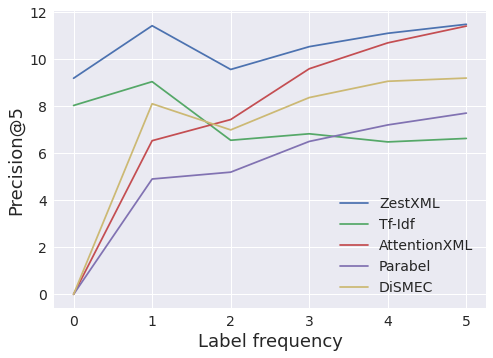

In [48]:
plt.xlabel('Label frequency', fontsize=18)
plt.ylabel('Precision@5', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for name, y in list(points.items()):
    plt.plot(y, label=name)
plt.legend(prop={'size' : 14})
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.savefig('/mnt/c/Users/t-nilgup/Pictures/decile-analysis.png', facecolor='w')
plt.savefig('/mnt/c/Users/t-nilgup/Pictures/decile-analysis.eps', facecolor='w')

## Analysis

### Prepare

In [117]:
Xf_Yf = read_bin_spmat(f'{RES_DIR}/model/Xf_Yf.bin')
Yf_Xf = read_bin_spmat(f'{RES_DIR}/model/Yf_Xf.bin')
sp_pattern_mat = Xf_Yf + Yf_Xf.T.tocsr()
Xf_Yf.nnz+Yf_Xf.nnz, sp_pattern_mat.nnz

loaded bin file in buffer
loaded bin file in buffer


(2217693, 2217693)

In [118]:
ind_sp_pattern_mat = sp_pattern_mat.copy().astype(np.int32)
temp = Xf_Yf.tocoo()
ind_sp_pattern_mat[temp.row, temp.col] = np.arange(Xf_Yf.nnz)
pair_xfs = [f'[x[{temp.row[i]}]({xfs[temp.row[i]]}) : y[{temp.col[i]}]({yfs[temp.col[i]]})]' for i in tqdm(range(temp.nnz))]

temp = Yf_Xf.tocoo()
ind_sp_pattern_mat[temp.col, temp.row] = np.arange(Xf_Yf.nnz, Xf_Yf.nnz+Yf_Xf.nnz)
for i in tqdm(range(temp.nnz)):
    pair_xfs.append(f'[x[{temp.col[i]}]({xfs[temp.col[i]]}) : y[{temp.row[i]}]({xfs[temp.row[i]]})]')
pair_xfs.append('bias')

100%|██████████| 224107/224107 [00:00<00:00, 585753.25it/s]


In [52]:
sp_pattern_mat = read_bin_spmat(f'{RES_DIR}/model/sparsity_pattern.bin')

loaded bin file in buffer


In [32]:
t_sp_pattern_mat = sp_pattern_mat.T.tocsr()

In [82]:
# xf = random.randrange(len(xfs))
xf = 20314
# xf = np.random.choice(targets)

print(f'xfs[{xf}] : {xfs[xf]}')
xf_sp_pattern_mat = sp_pattern_mat[xf]
sorted_inds = np.argsort(-xf_sp_pattern_mat.data)
for i, ind in enumerate(sorted_inds):
    print(f'{i+1}\t({"%.6f"%xf_sp_pattern_mat.data[ind]})\t{yfs[xf_sp_pattern_mat.indices[ind]]}')

xfs[20314] : dissolut
1	(0.500000)	dissolut
2	(0.075758)	czechoslovakia
3	(0.075758)	__label__2591__Czechoslovakia
4	(0.071138)	__parent__2291
5	(0.066964)	__label__1861__republic
6	(0.066288)	soviet
7	(0.066288)	ussr
8	(0.066288)	__label__2749__USSR; Soviet Union; former USSR
9	(0.066288)	former ussr
10	(0.066288)	ussr soviet
11	(0.066288)	soviet union
12	(0.066288)	union former
13	(0.051653)	__label__3183__ECSC; Consultative Committee of the ECSC; ECSC con
14	(0.051653)	high author
15	(0.051653)	ecsc ecsc
16	(0.051653)	ecsc consult
17	(0.051653)	consult committe
18	(0.051653)	communiti high
19	(0.051653)	committe ecsc
20	(0.039615)	__parent__5655
21	(0.039139)	__parent__26


In [147]:
yf = 1022682

print(f'yfs[{yf}] : {yfs[yf]}')
yf_sp_pattern_mat = t_sp_pattern_mat[yf]
sorted_inds = np.argsort(-yf_sp_pattern_mat.data)
for i, ind in enumerate(sorted_inds):
    print(f'{i+1}\t({"%.6f"%yf_sp_pattern_mat.data[ind]})\t{xfs[yf_sp_pattern_mat.indices[ind]]}')

yfs[1022682] : __label__81003__Anarchism
1	(0.192308)	cryptoparti
2	(0.138889)	wxlanarchist14
3	(0.119048)	9117285
4	(0.111111)	libsoc
5	(0.106383)	shirlow
6	(0.104167)	amielandmelburn
7	(0.102041)	96886
8	(0.100000)	parliamentarist
9	(0.096154)	22spirit
10	(0.081967)	pautz
11	(0.080645)	mountz
12	(0.074627)	54697
13	(0.068493)	especifismo
14	(0.067568)	hetsa
15	(0.064103)	melburn
16	(0.062500)	toc2
17	(0.060976)	uvali
18	(0.060241)	kesia
19	(0.058824)	32495
20	(0.057471)	20060329
21	(0.056818)	lierr
22	(0.056818)	frestonia
23	(0.049020)	31567
24	(0.047170)	20561
25	(0.045045)	20070514
26	(0.040650)	revoltlib
27	(0.039370)	titl anarch
28	(0.035211)	autarch
29	(0.035047)	social anarch
30	(0.026596)	hierarch organ
31	(0.026455)	stateless societi
32	(0.024272)	scmagazin
33	(0.018939)	lifework
34	(0.011628)	base free
35	(0.008190)	ideolog polit
36	(0.007153)	within societi


### Analyze single x, y pair

In [ ]:
bin_sp_pattern_mat = binarize(sp_pattern_mat, copy=True)

In [131]:
def bilinear_to_linear(x, y):
    cross = trn_X_Xf[x].T.dot(Y_Yf[y])
    data = cross.multiply(bin_sp_pattern_mat).data
    inds = binarize(cross).multiply(ind_sp_pattern_mat).data.astype(np.int32)
    del cross
    return csr_matrix((data, inds, [0, inds.shape[0]]), (1, sp_pattern_mat.nnz))

In [132]:
xy = normalize(bilinear_to_linear(0, 81003), axis=1)
print(get_text(0, pair_xfs, xy))

x = 0 : 
[x(anarch) : y(anarch)](0.99, 2875494) [x(anarch sidebar) : y(anarch)](0.15, 21988359)


In [244]:
prod = xy.dot(tree.shared_clf.data[:-1])+tree.shared_clf.data[-1]
bilinear_score = -((max(0, 1-prod))**2) - 0
np.exp(bilinear_score)

array([0.8450816], dtype=float32)

### Analyze predictions

In [401]:
targets = np.where((tst_X_Y - binarize(clf_score_mat.multiply(tst_X_Y))).getnnz(1) > 5)[0]

In [24]:
val_X[x]
print(get_text(x, xfs, val_X_Xf))

x = 0 : 
capit(0.36, 16272) capit movement(0.29, 66706) french oversea(0.28, 77427) oversea depart(0.28, 86238) algeria(0.27, 11929) oversea(0.25, 35674) provis treati(0.22, 89663) depart(0.21, 19660) movement(0.20, 33272) french(0.19, 23851) 1960(0.16, 3201) 11 may(0.14, 51554) 227(0.13, 4392) provis(0.11, 38162) applic area(0.09, 63952) articl 106(0.09, 64637) propos direct(0.09, 89204) pursuanc articl(0.09, 89840) econom condit(0.09, 73504) articl 69(0.09, 64808) depart wherea(0.09, 71579) wherea propos(0.09, 99220) treati concern(0.09, 97505) determin condit(0.09, 71795) social develop(0.09, 94387) ne(0.08, 33948) articl 67(0.08, 64806) council wherea(0.08, 70268) council determin(0.08, 70216) particular provis(0.08, 86732) decis applic(0.08, 71232) set first(0.08, 93595) treati particular(0.08, 97525) pursuanc(0.08, 38409) liberalis(0.08, 30510) forc 11(0.07, 77096) rest(0.07, 39733) treati regard(0.07, 97528) accord second(0.06, 61665) secretari(0.06, 41366) render(0.06, 39516) s

In [58]:
# x = random.randrange(tst_X_Y.shape[0])
x = 1

In [59]:
print(get_text(x, Y, val_X_Y, K=10, sep='\n', attr='bold', f = lambda ind, val : '%.2f, %s, %d'%(val, _c(nnz[ind], attr='blue'), ind)))

x = 1 : 
competition policy(1.00, 18, 1116)
control of restrictive practices(1.00, 5, 1671)
restriction on competition(1.00, 71, 1972)
inter-company agreement(1.00, 39, 2142)


In [60]:
print(get_text(x, Y, clf_score_mat, K=10, sep='\n', attr='bold', f = lambda ind, val : '%.2f, %s, %d'%(val, _c(nnz[ind], attr='blue'), ind)))

x = 1 : 
competition policy(0.44, 18, 1116)
control of restrictive practices(0.36, 5, 1671)
inter-company agreement(0.29, 39, 2142)
restriction on competition(0.21, 71, 1972)
specialisation agreement(0.11, 6, 1427)
ESC opinion(0.05, 1, 3044)
restrictive trade practice(0.05, 11, 4071)
common organisation of markets(0.05, 1609, 878)
free competition(0.05, 2, 494)
maritime transport(0.04, 76, 2691)


In [61]:
print(get_text(x, Y, bilinear_score_mat, K=10, sep='\n', attr='bold', f = lambda ind, val : '%.2f, %s, %d'%(val, _c(nnz[ind], attr='blue'), ind)))

x = 1 : 
inter-company agreement(0.66, 39, 2142)
restriction on competition(0.37, 71, 1972)
competitiveness(0.32, 24, 2668)
competition policy(0.32, 18, 1116)
sporting event(0.32, 18, 3447)
competition (EU)(0.32, 2, 2318)
specialisation agreement(0.31, 6, 1427)
control of restrictive practices(0.31, 5, 1671)
competition law(0.19, 31, 3232)
ESC opinion(0.09, 1, 3044)


In [57]:
print(get_text(x, Y, val_xshortlist, K=100, sep='\n', attr='bold', f = lambda ind, val : '%.2f, %s, %d'%(val, _c(nnz[ind], attr='blue'), ind)))

x = 0 : 
French overseas department and region(0.60, 155, 57)
overseas department (France)(0.24, 8, 2216)
French overseas collectivity(0.23, 3, 58)
capital movement(0.21, 12, 768)
export refund(0.19, 3554, 1962)
share capital(0.11, 7, 3092)
free movement of capital(0.10, 7, 489)
international sanctions(0.09, 698, 1908)
French Guiana(0.09, 15, 167)
balance of payments(0.09, 25, 2791)
overseas countries and territories(0.09, 115, 969)
capital increase(0.09, 10, 2348)
health control(0.08, 1599, 720)
capital goods(0.08, 0, 1716)
venture capital(0.08, 2, 3059)
investment(0.08, 19, 379)
Algeria(0.07, 34, 148)
France(0.07, 895, 56)
supply(0.07, 409, 966)
overseas territory(0.07, 2, 2625)
department (France)(0.07, 2, 2211)
capital market(0.07, 28, 3058)
working capital(0.07, 1, 39)
foreign capital(0.07, 84, 3112)
economic policy(0.06, 27, 1134)
EU aid(0.06, 1043, 4167)
early-stage capital(0.06, 1, 3914)
repatriation of capital(0.06, 1, 1468)
capital city(0.06, 12, 3101)
productivity(0.06, 3, 1

### Analyze bilinear

In [107]:
bilinear_clf = read_buf_bin_vec(open(f'{RES_DIR}/model/bilinear_clf.bin', 'rb').read(), np.float32)[0]

In [108]:
bilinear_clf.shape, sp_pattern_mat.nnz

((2217694,), 2217693)

In [110]:
bilinear_clf[-10:]

array([-0.5736173 ,  0.12871023,  0.4830132 ,  0.5849314 ,  0.82220685,
        0.7778163 ,  0.39703313, -0.04310488,  1.0390685 , -1.6236305 ],
      dtype=float32)

In [113]:
trn_xshortlist = read_bin_spmat(f'{RES_DIR}/model/shortlist.bin')
trn_linear_form_mat = read_bin_spmat(f'{RES_DIR}/model/linear_form_mat.bin')

sampled_tlfm = trn_linear_form_mat[:100000]

loaded bin file in buffer


In [123]:
x = 0
print(get_text(x, Y, trn_X_Y))
print(trn_X[x])

x = 0 : 
common transport policy(1.00, 1098) legal status(1.00, 2458) committee (EU)(1.00, 3679)
EEC Council: Rules of the Transport Committee. ,Having regard to Article 83 of the Treaty establishing the European Economic Community, which provides that an advisory committee consisting of experts designated by the Governments of Member States shall be attached to the Commission and consulted by the latter on transport matters whenever the Commission considers this desirable, without prejudice to the powers of the transport section of the Economic and Social Committee;Having regard to Article 153 of that Treaty, which provides that the Council shall, after receiving an opinion from the Commission, determine the rules governing the committees provided for in that Treaty;Having received an Opinion from the Commission;. that the Rules of the Transport Committee shall be as follows: The Committee shall consist of experts on transport matters designated by the Governments of Member States. Ea

In [125]:
print(get_text(0, pair_xfs, sampled_tlfm, sep='\n', f = lambda ind, val : '%s, %s, %d'%(_c('%.2f'%val, attr='green'), _c('%.2f'%bilinear_clf[ind], attr='blue'), ind)))

x = 0 : 
bias(1.00, -1.62, 2217693)
[x[79870](inland waterway) : y[18786](waterway fleet)](0.28, 0.62, 1590268)
[x[79870](inland waterway) : y[19096](__label__25__inland waterway fleet)](0.28, 0.62, 1590272)
[x[47754](waterway) : y[18786](waterway fleet)](0.28, 0.14, 947801)
[x[47754](waterway) : y[19096](__label__25__inland waterway fleet)](0.28, 0.14, 947805)
[x[79870](inland waterway) : y[11352](inland waterway)](0.25, -0.12, 1590261)
[x[47754](waterway) : y[11352](inland waterway)](0.25, 0.20, 947794)
[x[79870](inland waterway) : y[23935](__parent__4515)](0.25, -0.05, 1590275)
[x[47754](waterway) : y[23935](__parent__4515)](0.24, 0.27, 947808)
[x[27594](inland) : y[11352](inland waterway)](0.24, -0.01, 547844)
[x[79870](inland waterway) : y[2135](inland)](0.24, -0.41, 1590257)
[x[79870](inland waterway) : y[4367](waterway)](0.24, -0.14, 1590258)
[x[27594](inland) : y[23935](__parent__4515)](0.24, 0.15, 547858)
[x[47754](waterway) : y[4367](waterway)](0.23, 0.16, 947791)
[x[47754](w

In [81]:
sorted_inds = np.argsort(-bilinear_clf)
for i in sorted_inds[:100]:
    print(pair_xfs[i], bilinear_clf[i])

[x[20314](dissolut) : y[20867](__label__1861__republic)] 8.824594
[x[96944](thereto 2) : y[23208](fingal)] 7.322508
[x[99134](wherea implement) : y[19152](__label__84__fruit)] 7.0405354
[x[79278](import valu) : y[23208](fingal)] 6.2630157
[x[66422](buy skim) : y[19497](__label__441__milk)] 5.98454
[x[61285](97 tabl) : y[9931](fix amount)] 5.8275075
[x[79225](import price) : y[11084](import price)] 5.681644
[x[37698](presidentjoao) : y[20867](__label__1861__republic)] 5.513355
[x[32192](melon) : y[2561](melon)] 5.4899225
[x[32428](mexico) : y[2591](mexico)] 5.399579
[x[95261](statist nomenclatur) : y[17149](statist nomenclatur)] 5.362549
[x[96430](tariff concess) : y[17545](tariff concess)] 5.25389
[x[55338](2009 protect) : y[11079](import eu)] 5.1911826
[x[55338](2009 protect) : y[6872](communiti import)] 5.1911826
[x[72547](duti level) : y[21313](__label__2323__customs duties)] 5.1337233
[x[13520](aubergin) : y[269](aubergin)] 5.054527
[x[99134](wherea implement) : y[19522](__label__4

In [464]:
learnt_sp_pattern_mat = sp_pattern_mat.copy()

(1108383,)

In [39]:
shortlist = (tst_X_Xf.dot(binarize(sp_pattern_mat, copy=True))).dot(Y_Xf.T)
# shortlist = (tst_X_Xf.dot(binarize(sp_pattern_mat, copy=True))).dot(Y_Xf.T)

In [40]:
topk_shortlist = xclib.utils.sparse.retain_topk(shortlist.copy(), copy=False, k=100)

In [10]:
trn_xshortlist = read_bin_spmat(f'{RES_DIR}/trn_xshortlist.bin')
tst_xshortlist = read_bin_spmat(f'{RES_DIR}/tst_xshortlist.bin')

loaded bin file in buffer
loaded bin file in buffer


In [15]:
inv_valid_labels

In [19]:
trn_xshortlist.getnnz(0)[inv_valid_labels(np.where((nnz > 0) & (nnz <= 5))[0])].mean()

625.8653084323713

In [458]:
recall(topk_shortlist, tst_X_Y, K=[1, 50, 100, 500, 1000])

{'R@1': 13.144911584516846,
 'R@50': 60.26923516971504,
 'R@100': 68.9052960978077,
 'R@500': 68.9052960978077,
 'R@1000': 68.9052960978077}

In [298]:
recall(temp, trn_X_Y, K=[100, 500, 1000])

{'R@100': 73.54989315912846,
 'R@500': 87.95412884591806,
 'R@1000': 89.36961768297063}

In [37]:
temp = tst_X_Xf.dot(Y_Xf.T)

In [34]:
alpha = 0.95
score_mat = alpha*clf_score_mat + (1-alpha)*tst_

In [123]:
direct_xf_yf = read_bin_spmat(f'/scratch/nilesh/experiments/genexml/Results/{dataset}/model/direct_Xf_Yf.bin').tocoo()

loaded bin file in buffer


In [124]:
direct_xf_yf.nnz

6300

In [22]:
ind = 798
xfs[direct_xf_yf.row[ind]], yfs[direct_xf_yf.col[ind]]

('contain', 'contain')

In [28]:
alpha = 0.9; beta = 0.05; gamma = 0.05
score_mat = normalize(clf_score_mat, norm="max")*alpha + normalize(bilinear_score_mat, norm="max")*beta + normalize(knn_score_mat, norm="max")*gamma

In [166]:
clf_score_mat = read_bin_spmat(f'{RES_DIR}/clf_score_mat.bin').copy()
bilinear_score_mat = read_bin_spmat(f'{RES_DIR}/bilinear_score_mat.bin').copy()
knn_score_mat = read_bin_spmat(f'{RES_DIR}/knn_score_mat.bin').copy()

# # trn_xshortlist = read_bin_spmat(f'{RES_DIR}/trn_xshortlist.bin')
# tst_xshortlist = read_bin_spmat(f'{RES_DIR}/shortlist.bin')

loaded bin file in buffer
loaded bin file in buffer
loaded bin file in buffer


In [168]:
get_irm_metrics(bilinear_score_mat);
# get_irm_metrics(tst_X_Y);
# get_irm_metrics(tst_xshortlist);

GZSL metrics (shape=(6000, 4271)): 


,1,2,3,4,5
P,87.33,79.71,71.64,63.31,55.72
nDCG,87.33,81.65,76.62,72.75,70.11
PSP,48.95,52.56,53.53,53.22,52.63
PSnDCG,48.95,51.69,52.63,52.88,52.94


FewShot metrics (shape=(524, 1930)): 


,1,2,3,4,5
P,17.56,12.50,10.24,8.59,7.4
nDCG,17.56,19.35,21.33,22.51,23.3


SZSL metrics (shape=(89, 163)): 


,1,2,3,4,5
P,29.21,21.91,14.98,11.52,9.21
nDCG,29.21,35.16,35.72,36.20,36.20


XC metrics (shape=(6000, 4108)): 


,1,2,3,4,5
P,87.48,79.89,71.86,63.50,55.84
nDCG,87.48,81.83,76.83,72.97,70.30
PSP,50.91,54.16,55.01,54.57,53.84
PSnDCG,50.91,53.37,54.22,54.37,54.32
